<a href="https://colab.research.google.com/github/akhilesh-reddyy/Retail-Sales-Forecasting/blob/main/online_retail_sales_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import pandas as pd

# Correct way to read Excel files
df = pd.read_excel("/content/online_retail_II.xlsx", sheet_name="Year 2010-2011")
print(df.head())


  Invoice StockCode                          Description  Quantity  \
0  536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1  536365     71053                  WHITE METAL LANTERN         6   
2  536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3  536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4  536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  Price  Customer ID         Country  
0 2010-12-01 08:26:00   2.55      17850.0  United Kingdom  
1 2010-12-01 08:26:00   3.39      17850.0  United Kingdom  
2 2010-12-01 08:26:00   2.75      17850.0  United Kingdom  
3 2010-12-01 08:26:00   3.39      17850.0  United Kingdom  
4 2010-12-01 08:26:00   3.39      17850.0  United Kingdom  


In [11]:
print(df.columns)

df.columns = df.columns.str.strip()


Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country'],
      dtype='object')


Index(['invoice', 'stockcode', 'description', 'quantity', 'invoicedate',
       'price', 'customer_id', 'country'],
      dtype='object')
MSE: 950367063.4249009


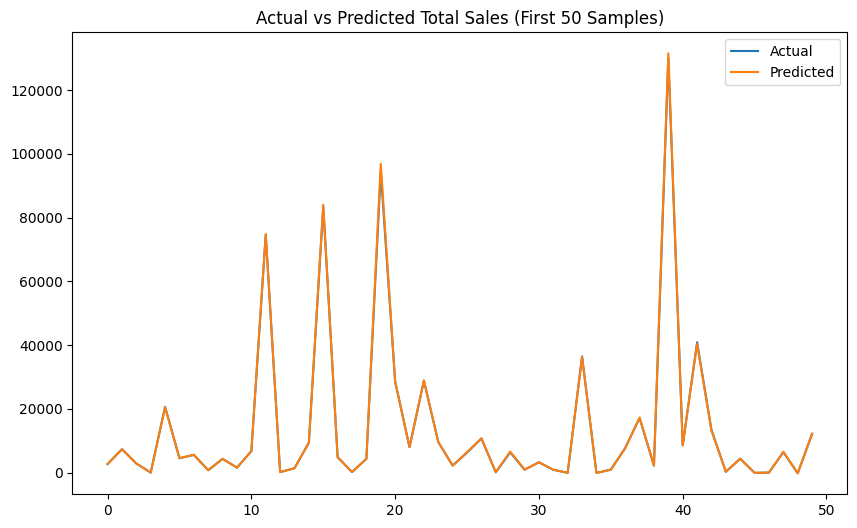

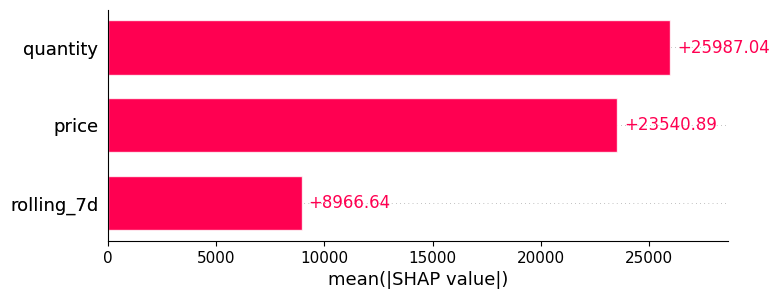

<Figure size 640x480 with 0 Axes>

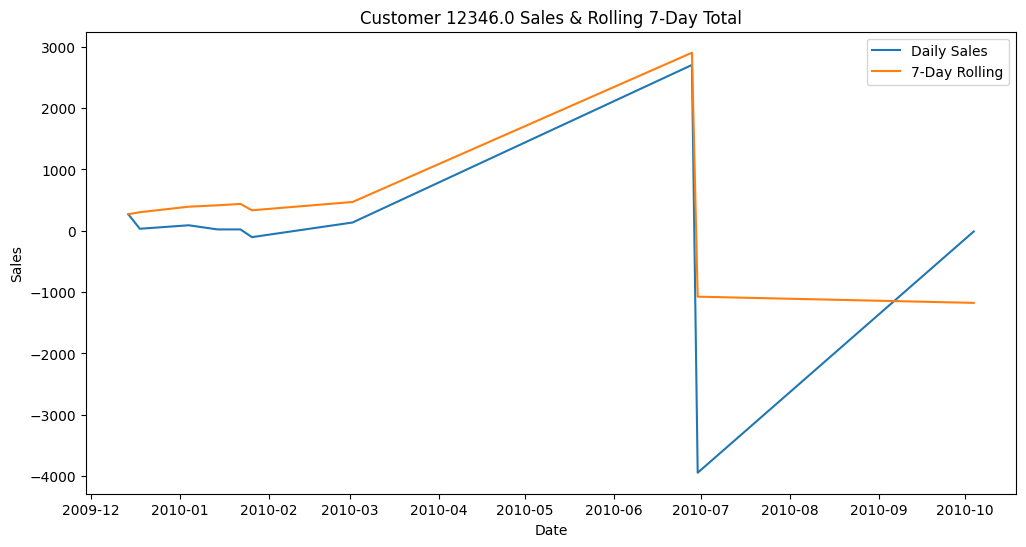

In [28]:
# ---------------------------
# 1. Imports
# ---------------------------
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import shap

# ---------------------------
# 2. Preprocessing
# ---------------------------
# Normalize column names: lowercase, strip spaces, replace spaces with underscore
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

print(df.columns)
# Output: Index(['invoice', 'stockcode', 'description', 'quantity', 'invoicedate', 'price', 'customer_id', 'country'], dtype='object')

# Drop missing customer_id
df = df.dropna(subset=['customer_id'])

# Convert invoice date to datetime
df['invoicedate'] = pd.to_datetime(df['invoicedate'])

# Ensure price and quantity are numeric
df['price'] = pd.to_numeric(df['price'], errors='coerce')
df['quantity'] = pd.to_numeric(df['quantity'], errors='coerce')
df = df.dropna(subset=['price', 'quantity'])

# ---------------------------
# 3. Aggregate daily sales per customer
# ---------------------------
daily_sales = df.groupby(['customer_id', df['invoicedate'].dt.date])[['quantity', 'price']].sum()
daily_sales['total_sales'] = daily_sales['quantity'] * daily_sales['price']
daily_sales = daily_sales.reset_index()
daily_sales.rename(columns={'invoicedate':'date'}, inplace=True)

# Compute rolling 7-day total per customer
daily_sales['rolling_7d'] = daily_sales.groupby('customer_id')['total_sales'] \
                                      .transform(lambda x: x.rolling(7, min_periods=1).sum())

# ---------------------------
# 4. Prepare features & target
# ---------------------------
X = daily_sales[['quantity', 'price', 'rolling_7d']].copy()
y = daily_sales['total_sales']

# Scale features
scaler = StandardScaler()
X[['quantity','price','rolling_7d']] = scaler.fit_transform(X[['quantity','price','rolling_7d']])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ---------------------------
# 5. Train RandomForestRegressor
# ---------------------------
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

# MSE
mse = mean_squared_error(y_test, y_pred)
print("MSE:", mse)

# ---------------------------
# 6. Plot Actual vs Predicted
# ---------------------------
plt.figure(figsize=(10,6))
plt.plot(y_test.values[:50], label="Actual")
plt.plot(y_pred[:50], label="Predicted")
plt.title("Actual vs Predicted Total Sales (First 50 Samples)")
plt.legend()
plt.savefig("actual_vs_predicted.png")
plt.show()

# ---------------------------
# 7. SHAP Interpretability
# ---------------------------
explainer = shap.TreeExplainer(rf)
shap_values = explainer(X_test[:500])

# Bar summary
shap.plots.bar(shap_values, max_display=10)
plt.savefig("shap_summary.png")

# ---------------------------
# 8. Optional: Rolling 7-day plot for a sample customer
# ---------------------------
plt.figure(figsize=(12,6))
sample_customer = daily_sales['customer_id'].iloc[0]
customer_sales = daily_sales[daily_sales['customer_id']==sample_customer]
plt.plot(customer_sales['date'], customer_sales['total_sales'], label="Daily Sales")
plt.plot(customer_sales['date'], customer_sales['rolling_7d'], label="7-Day Rolling")
plt.title(f"Customer {sample_customer} Sales & Rolling 7-Day Total")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()

